# Прогнозирование заказов такси

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

Инструкция по выполнению проекта:
- Загрузить данные и выполните их ресемплирование по одному часу.
- Проанализировать данные.
- Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
- Проверить данные на тестовой выборке и сделать выводы.

Описание данных

Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

## Цели

Постройить модель для предсказания. Значение метрики RMSE на тестовой выборке должно быть не больше 48.

In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset


Загружаем данные и чекаем что у нас там есть

In [2]:

try:
    data = pd.read_csv('taxi.csv')
except FileNotFoundError:
    data = pd.read_csv('/datasets/taxi.csv')

In [3]:
data

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Данные без пропусков

In [5]:
data = data.set_index('datetime')

data.index = pd.to_datetime(data.index)

поменяли индекс на дату

In [6]:
data.index.is_monotonic_increasing

True

Данные упорядочены в хронологическом порядке

In [7]:
data.head(11)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [8]:
data.tail(11)

,num_orders
datetime,
2018-08-31 22:10:00,32
2018-08-31 22:20:00,48
2018-08-31 22:30:00,41
2018-08-31 22:40:00,34
2018-08-31 22:50:00,34
2018-08-31 23:00:00,30
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [9]:
data = data.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


ресемплировали по часу

<Axes: xlabel='datetime'>

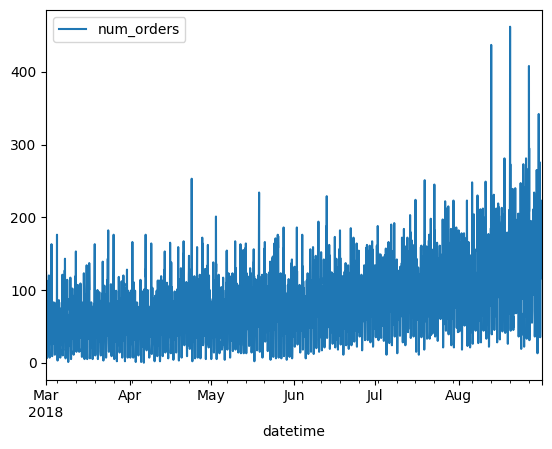

In [10]:
data.plot()

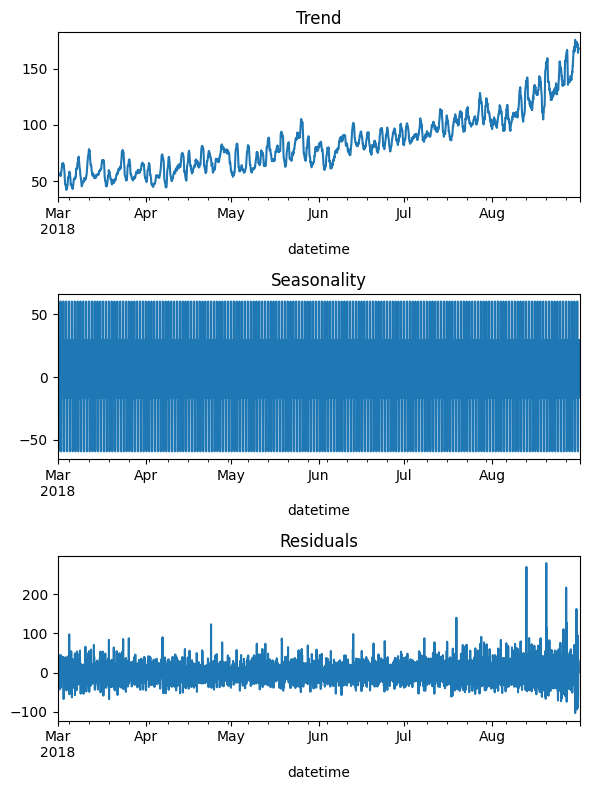

In [11]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

видим, что есть четко выраженный восходящий тренд по количеству заказов. Такой тренд может указывать на рост бизнеса и/или сезонное увеличение спроса или другие факторы, влияющие на рост количества заказов.

График сезонности показывает, что в данных присутствуют регулярные колебания, которые повторяются через постоянные промежутки времени. Это может быть связано с дневной или недельной сезонностью (например, увеличение заказов в определенные дни недели или часы).

График шума(остатков) в основном сконцентрированы значения около нуля

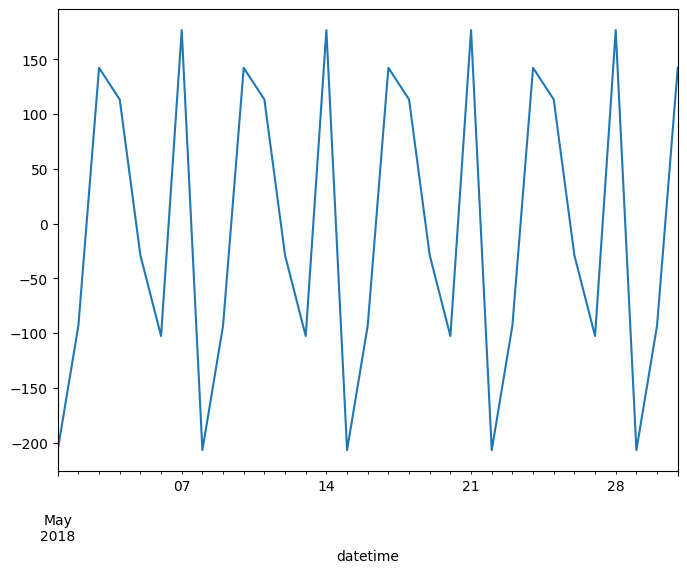

In [12]:
data2 = data['2018-05-01':'2018-05-31'].resample('1D').sum()
decomposed2 = seasonal_decompose(data2, period=7)

plt.figure(figsize=(8, 6))
decomposed2.seasonal.plot()
plt.show()



если смотреть сезонность, например, в мае, то можно увидеть сильный спад спроса каждый второй и шестой день. Если временную ось поделить на равные 7дневные отрезки. Условно если 1ое мая это понедельник, то каждый вторник и субботу наблюдается спад

Создадим дополнительные признак и функцию, которая будет генерить колво смещений и окно скользящего среднего

In [13]:
def part_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    data = data.copy()
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['part_day'] = data['hour'].apply(part_day)
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

    data.fillna(0, inplace=True)
    features = data.drop('num_orders', axis=1)
    return features

In [15]:
results = []

## Построение моделей

модели, которые буду рассматривать: решающее дерево, случайный лес, CatBoost и нейронка. с каждой моделью планирую перебор небольшого диапазона парамтеров для создания признаком временного ряда. А так же перебор гипперпараметров для каждой модели. Ищем лучший результат rmse, и модель с лучшим rmse получит возможность показать себя на тесте

In [16]:
y = data['num_orders']

### Decision Tree

In [17]:
tscv = TimeSeriesSplit(n_splits=5)

top_rmse_dt = float('inf')
top_params_dt = None
top_make_params_dt = None

for max_lag in np.arange(4, 25, 4):
    for rolling_mean_size in np.arange(1, 6):
        
        data_transformed = make_features(data, max_lag, rolling_mean_size)

        column_transformer = ColumnTransformer([
            ("ohe", OneHotEncoder(), ['part_day'])
        ], remainder='passthrough')

        data_transformed_encoded = column_transformer.fit_transform(data_transformed)
        data_transformed_encoded = pd.DataFrame(data_transformed_encoded, index=data_transformed.index)

        X_train, X_test, y_train, y_test = train_test_split(data_transformed_encoded, y, test_size=0.1,
                                                            shuffle=False)

        # Параметры
        param_distributions = {
            'max_depth': np.arange(1, 30, 5),
            'min_samples_split': np.arange(2, 6),
            'min_samples_leaf': np.arange(1, 6)
        }

        # Создание модели RandomizedSearchCV
        randomized_search = RandomizedSearchCV(DecisionTreeRegressor(), param_distributions, 
                                               n_iter=10, cv=tscv, scoring='neg_root_mean_squared_error', 
                                               random_state=1234)

        # Обучение
        randomized_search.fit(X_train, y_train)

        # Лучшие параметры и RMSE
        best_params_dt = randomized_search.best_params_
        best_rmse_dt = -randomized_search.best_score_
        
        if best_rmse_dt < top_rmse_dt:
            top_rmse_dt = best_rmse_dt
            top_params_dt = best_params_dt
            top_make_params_dt = (max_lag, rolling_mean_size)

print("Лучшие параметры для временного ряда: мах колво отстающих значений - ", top_make_params_dt[0],
     'ширина окна для скользяшего среднего', top_make_params_dt[1])
print("Лучшие параметры для решающего дерева:", top_params_dt)
print("Лучший RMSE для решающего дерева:", top_rmse_dt)

Лучшие параметры для временного ряда: мах колво отстающих значений -  24 ширина окна для скользяшего среднего 5
Лучшие параметры для решающего дерева: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 6}
Лучший RMSE для решающего дерева: 29.703044433743646


Получили неплохой результат RMSE = 29.7 при колво отстающих значений = 24 и ширине окна для скользящего среднего = 5. так же при гипперпараметрах решающего дерева: min_samples_split: 5, min_samples_leaf: 2, max_depth: 6

In [18]:
results.append({
    'Make_params': top_make_params_dt,
    'Model': 'Decision Tree',
    'Model params': top_params_dt,
    'RMSE': top_rmse_dt,
})

results_df = pd.DataFrame(results)

results_df

,Make_params,Model,Model params,RMSE
0,"(24, 5)",Decision Tree,"{'min_samples_split': 5, 'min_samples_leaf': 2...",29.703044


### Random forest

делаем тоже самое для случайного леса

In [19]:
tscv = TimeSeriesSplit(n_splits=5)

top_rmse_rf = float('inf')
top_params_rf = None
top_make_params_rf = None

for max_lag in np.arange(4, 25, 4):
    for rolling_mean_size in np.arange(1, 6):
        
        data_transformed = make_features(data, max_lag, rolling_mean_size)

        column_transformer = ColumnTransformer([
            ("ohe", OneHotEncoder(), ['part_day'])
        ], remainder='passthrough')

        data_transformed_encoded = column_transformer.fit_transform(data_transformed)
        data_transformed_encoded = pd.DataFrame(data_transformed_encoded, index=data_transformed.index)

        X_train, X_test, y_train, y_test = train_test_split(data_transformed_encoded, y, test_size=0.1,
                                                            shuffle=False)

        # Параметры
        param_distributions = {
            'n_estimators': np.arange(1, 101, 10),
            'max_depth': np.arange(1, 30, 5),
            'min_samples_split': np.arange(2, 6)
        }

        # Создание модели RandomizedSearchCV
        randomized_search = RandomizedSearchCV(RandomForestRegressor(), param_distributions, 
                                               n_iter=10, cv=tscv, scoring='neg_root_mean_squared_error', 
                                               random_state=1234)

        # Обучение
        randomized_search.fit(X_train, y_train)

        # Лучшие параметры и RMSE
        best_params_rf = randomized_search.best_params_
        best_rmse_rf = -randomized_search.best_score_
        
        if best_rmse_rf < top_rmse_rf:
            top_rmse_rf = best_rmse_rf
            top_params_rf = best_params_rf
            top_make_params_rf = (max_lag, rolling_mean_size)

print("Лучшие параметры для временного ряда: мах колво отстающих значений - ", top_make_params_rf[0],
     'ширина окна для скользяшего среднего', top_make_params_rf[1])
print("Лучшие параметры для случайного леса:", top_params_rf)
print("Лучший RMSE для случайного леса:", top_rmse_rf)

Лучшие параметры для временного ряда: мах колво отстающих значений -  24 ширина окна для скользяшего среднего 2
Лучшие параметры для случайного леса: {'n_estimators': 61, 'min_samples_split': 4, 'max_depth': 26}
Лучший RMSE для случайного леса: 25.102993292626333


Получили неплохой результат RMSE = 25.10 при колво отстающих значений = 24 и ширине окна для скользящего среднего = 2. так же при гипперпараметрах случайного леса: n_estimators: 61, min_samples_split: 4, max_depth: 26

In [20]:
results.append({
    'Make_params': top_make_params_rf,
    'Model': 'Random Forest',
    'Model params': top_params_rf,
    'RMSE': top_rmse_rf,
})

results_df = pd.DataFrame(results)

results_df

,Make_params,Model,Model params,RMSE
0,"(24, 5)",Decision Tree,"{'min_samples_split': 5, 'min_samples_leaf': 2...",29.703044
1,"(24, 2)",Random Forest,"{'n_estimators': 61, 'min_samples_split': 4, '...",25.102993


### Catboost

проходим тот же алгоритм для СВ

In [21]:
top_rmse_cb = float('inf')
top_params_cb = None
top_make_params_cb = None

tscv = TimeSeriesSplit(n_splits=5)

for max_lag in np.arange(4, 25, 4):
    for rolling_mean_size in np.arange(1, 6):
        data_transformed = make_features(data, max_lag, rolling_mean_size)

        for itera in [int(x) for x in np.arange(500, 2001, 500)]:
            local_rmse_cb = []
            
            for train_index, test_index in tscv.split(data_transformed):
                X_train, X_valid = data_transformed.iloc[train_index], data_transformed.iloc[test_index]
                y_train, y_valid = y.iloc[train_index], y.iloc[test_index]

                model = CatBoostRegressor(iterations=itera, cat_features=['part_day'], verbose=False)
                model.fit(X_train, y_train)

                y_pred = model.predict(X_valid)
                rmse = mean_squared_error(y_valid, y_pred) ** 0.5
                local_rmse_cb.append(rmse)
            
            mean_rmse_cb = np.mean(local_rmse_cb)
            if mean_rmse_cb < top_rmse_cb:
                top_rmse_cb = mean_rmse_cb
                top_params_cb = itera
                top_make_params_cb = (max_lag, rolling_mean_size)

# Вывод лучших параметров
print("Лучшие параметры для временного ряда: мах колво отстающих значений - ", top_make_params_cb[0],
     'ширина окна для скользяшего среднего', top_make_params_cb[1])
print("Лучшие параметры для Catboost: iterations = {}".format(top_params_cb))
print("Лучший RMSE для Catboost: {:.2f}".format(top_rmse_cb))

Лучшие параметры для временного ряда: мах колво отстающих значений -  24 ширина окна для скользяшего среднего 1
Лучшие параметры для Catboost: iterations = 2000
Лучший RMSE для Catboost: 27.05


Получили неплохой результат RMSE = 27.05 при колво отстающих значений = 24 и ширине окна для скользящего среднего = 1. так же при 2000 итерациях

In [22]:
results.append({
    'Make_params': top_make_params_cb,
    'Model': 'Catboost',
    'Model params': top_params_cb,
    'RMSE': top_rmse_cb,
})

results_df = pd.DataFrame(results)

results_df

,Make_params,Model,Model params,RMSE
0,"(24, 5)",Decision Tree,"{'min_samples_split': 5, 'min_samples_leaf': 2...",29.703044
1,"(24, 2)",Random Forest,"{'n_estimators': 61, 'min_samples_split': 4, '...",25.102993
2,"(24, 1)",Catboost,2000,27.045351


### Нейронная сеть

In [29]:
# создаем НС
class Net(nn.Module):
    def __init__(self, input_dim, num_units, num_layers, dropout, activation_function):
        super(Net, self).__init__()
        self.layers = nn.ModuleList()
        
        # Входной
        self.layers.append(nn.Linear(input_dim, num_units))
        
        # Скрытые
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(num_units, num_units))
        
        # Выходной
        self.out = nn.Linear(num_units, 1)
        self.dropout = nn.Dropout(dropout)
        
        # Функция активации
        if activation_function == 'relu':
            self.activation = F.relu
        elif activation_function == 'sigmoid':
            self.activation = torch.sigmoid
        elif activation_function == 'tanh':
            self.activation = torch.tanh

    def forward(self, x):
        for layer in self.layers:
            x = self.activation(layer(x))
            x = self.dropout(x)
        x = self.out(x)
        return x

In [30]:
# Функции обучения и оценки
def train(model, optimizer, loader, criterion):
    model.train()
    for batch_X, batch_y in loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        predictions = predictions.squeeze()
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()

def evaluate(model, loader):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for batch_X, batch_y in loader:
            predictions = model(batch_X)
            predictions = predictions.squeeze()  # Уменьшение размерности предсказаний
            all_preds.extend(predictions.numpy())
    return all_preds

In [31]:
# Функция для перебора гиперпараметров рандомно
def random_combinations(param_distributions, n_iter=10):
    combinations = []
    for _ in range(n_iter):
        params = {key: np.random.choice(values) for key, values in param_distributions.items()}
        combinations.append(params)
    return combinations

# Функция для разделения данных с учетом временной структуры
def time_series_split(X, y, n_splits):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_index, test_index in tscv.split(X):
        X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
        yield X_train, X_valid, y_train, y_valid

# Параметры для перебора гиперпараметров нейронной сети
param_distributions = {
    'lr': [0.001, 0.01, 0.1],
    'num_units': [50, 100, 150],
    'num_layers': [1, 2, 3],
    'dropout': [0.1, 0.2, 0.3, 0.4, 0.5],
    'activation_function': ['relu', 'sigmoid', 'tanh']
}

combinations = random_combinations(param_distributions, n_iter=10)

In [32]:
top_rmse = float('inf')
top_params = None
top_make_params = None

for max_lag in np.arange(4, 25, 4):
    for rolling_mean_size in np.arange(1, 6):
        data_transformed = make_features(data, max_lag, rolling_mean_size)
        
        column_transformer = ColumnTransformer([
            ("ohe", OneHotEncoder(), ['part_day'])
        ], remainder='passthrough')

        data_transformed_encoded = column_transformer.fit_transform(data_transformed)
        data_transformed_encoded = pd.DataFrame(data_transformed_encoded, index=data_transformed.index)
        y = data['num_orders']

        for X_train, X_valid, y_train, y_valid in time_series_split(data_transformed_encoded, y, n_splits=5):
            # Преобразование DF в NumPy массивы
            X_train_array = X_train.values
            y_train_array = y_train.values
            X_valid_array = X_valid.values
            y_valid_array = y_valid.values

            # Создание тензоров PyTorch
            X_train_tensor = torch.FloatTensor(X_train_array)
            y_train_tensor = torch.FloatTensor(y_train_array)
            X_valid_tensor = torch.FloatTensor(X_valid_array)
            y_valid_tensor = torch.FloatTensor(y_valid_array)

            # Создание DataLoader
            train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
            train_loader = DataLoader(train_dataset, batch_size=32)
            valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
            valid_loader = DataLoader(valid_dataset, batch_size=32)

            # Перебор гиперпараметров
            for params in combinations:
                model = Net(X_train.shape[1], params['num_units'], params['num_layers'], 
                            params['dropout'], params['activation_function'])

                optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
                criterion = nn.MSELoss()

                # Обучение модели
                for epoch in range(5):
                    train(model, optimizer, train_loader, criterion)

                # Оценка модели
                y_pred = evaluate(model, valid_loader)
                rmse = np.sqrt(mean_squared_error(y_valid, y_pred))

                if rmse < top_rmse:
                    top_rmse = rmse
                    top_params = params
                    top_make_params = (max_lag, rolling_mean_size)

# Вывод лучших параметров
print("Лучшие параметры для временного ряда: мах колво отстающих значений - ", top_make_params[0],
     'ширина окна для скользяшего среднего', top_make_params[1])
print("Лучшие параметры:", top_params)
print("Лучший RMSE:", top_rmse)


Лучшие параметры для временного ряда: мах колво отстающих значений -  24 ширина окна для скользяшего среднего 1
Лучшие параметры: {'lr': 0.01, 'num_units': 100, 'num_layers': 1, 'dropout': 0.4, 'activation_function': 'relu'}
Лучший RMSE: 23.290622958399748


In [35]:
results.append({
    'Make_params': top_make_params,
    'Model': 'NN',
    'Model params': top_params,
    'RMSE': top_rmse,
})

results_df = pd.DataFrame(results)

results_df

,Make_params,Model,Model params,RMSE
0,"(24, 5)",Decision Tree,"{'min_samples_split': 5, 'min_samples_leaf': 2...",29.703044
1,"(24, 2)",Random Forest,"{'n_estimators': 61, 'min_samples_split': 4, '...",25.102993
2,"(24, 1)",Catboost,2000,27.045351
3,"(24, 1)",NN,"{'lr': 0.01, 'num_units': 100, 'num_layers': 1...",23.290623


Получили неплохой результат RMSE = 23.29 при колво отстающих значений = 24 и ширине окна для скользящего среднего = 1. и при гипперпараметрах НС: 'lr': 0.01, 'num_units': 100, 'num_layers': 1, 'dropout': 0.4, 'activation_function': 'relu'

In [36]:
results_df

,Make_params,Model,Model params,RMSE
0,"(24, 5)",Decision Tree,"{'min_samples_split': 5, 'min_samples_leaf': 2...",29.703044
1,"(24, 2)",Random Forest,"{'n_estimators': 61, 'min_samples_split': 4, '...",25.102993
2,"(24, 1)",Catboost,2000,27.045351
3,"(24, 1)",NN,"{'lr': 0.01, 'num_units': 100, 'num_layers': 1...",23.290623


по итоговой таблице, видим, что модель НН показала себя лучше всего, поэтому ее мы и выберем для оценки на тесте

### Test

In [37]:
best_params = top_params
best_max_lag = top_make_params[0]
best_rolling_mean_size = top_make_params[1]

# Создание и обучение модели на полном наборе обучающих данных
data_transformed = make_features(data, best_max_lag, best_rolling_mean_size)

column_transformer = ColumnTransformer([
    ("ohe", OneHotEncoder(), ['part_day'])
], remainder='passthrough')

data_transformed_encoded = column_transformer.fit_transform(data_transformed)
data_transformed_encoded = pd.DataFrame(data_transformed_encoded, index=data_transformed.index)

X_train, X_test, y_train, y_test = train_test_split(data_transformed_encoded, y, test_size=0.1, shuffle=False)

# Преобразование в тензоры
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.FloatTensor(y_train.values)
X_test_tensor = torch.FloatTensor(X_test.values)

# Создание DataLoader для обучающих данных
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32)

# Создание и обучение модели
model = Net(X_train.shape[1], best_params['num_units'], best_params['num_layers'], 
            best_params['dropout'], best_params['activation_function'])

optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
criterion = nn.MSELoss()

# Обучение модели
for epoch in range(5):
    train(model, optimizer, train_loader, criterion)

# Предсказание на тестовых данных
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor)
    y_test_pred = y_test_pred.squeeze().numpy()

# Оценка производительности на тестовых данных
rmse_nn = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("RMSE на тестовой выборке:", rmse_nn)


RMSE на тестовой выборке: 44.10977116953161


Результат получился 44, отлично

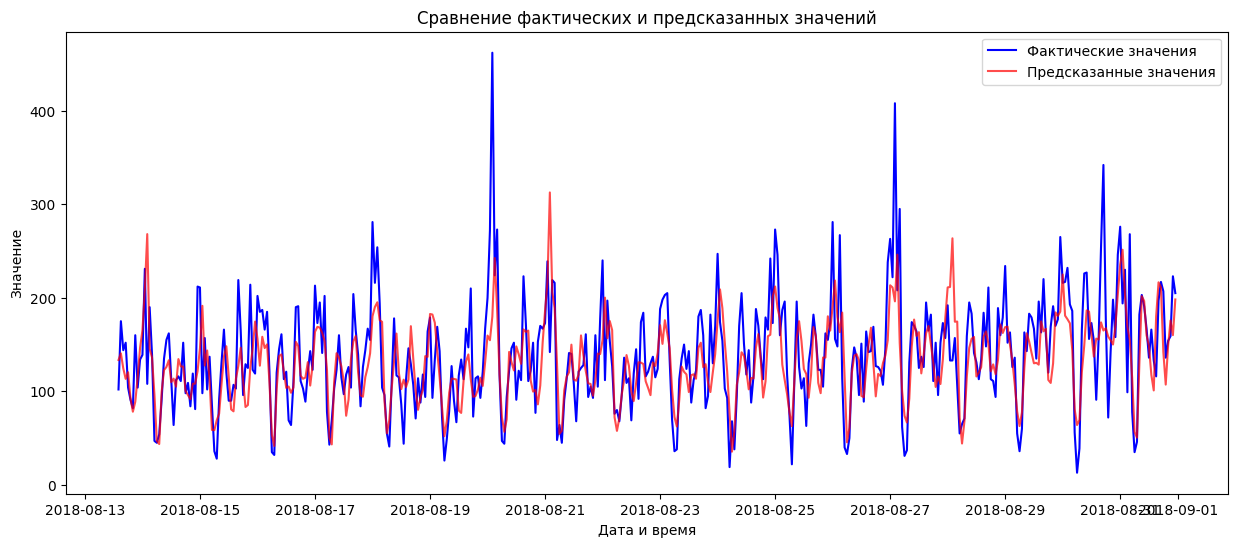

In [38]:
y_test_array = y_test.values

# Создаем временные метки для тестовой выборки (если они уже не созданы)
test_timestamps = data_transformed_encoded.index[-len(y_test):]

# Визуализация
plt.figure(figsize=(15, 6))
plt.plot(test_timestamps, y_test_array, label='Фактические значения', color='blue')
plt.plot(test_timestamps, y_test_pred, label='Предсказанные значения', color='red', alpha=0.7)
plt.title('Сравнение фактических и предсказанных значений')
plt.xlabel('Дата и время')
plt.ylabel('Значение')
plt.legend()
plt.show()

## Вывод


- провели исследвоание временного ряда
- создали функцию перебора параметров для временного ряда с созданием дополниткльных признаков
- построили 4 модели: Решающее дерево, Случайный лес, CatBoost и нейронная сеть
- по итогу лучший результат показала модель нейронных сетей - 23.29, со следующими параметрами: колво отстающих значений = 24 и ширине окна для скользящего среднего = 1. и при гипперпараметрах НС: 'lr': 0.01, 'num_units': 100, 'num_layers': 1, 'dropout': 0.4, 'activation_function': 'relu'
- и на тесте эта же модлеь показала уже результат в 44.11
- визуализировали результат на графике, на котором видны предсказания модели и фактические значения 